In [1]:
# Predice en test dataset todos los boxes, labels, y scores.

In [2]:
from __future__ import absolute_import, division, print_function
import os

PREF = '074a01a' 
KAGGLE = 'KAGGLE_WORKING_DIR' in os.environ
COLAB = 'COLAB_GPU' in os.environ

import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import random
from multiprocessing import Pool, cpu_count
import tensorflow as tf
from keras import backend as K
import keras
from PIL import Image
from PIL import ImageOps
import cv2

import time

kernel_time = time.time()

def tic_tac(restart):
    global kernel_time 
    
    if restart:
        kernel_time = time.time()
    else:
        t_sec = round(time.time() - kernel_time)
        (t_min, t_sec) = divmod(t_sec,60)
        (t_hour,t_min) = divmod(t_min,60) 
        print('Time passed: {}hour:{}min:{}sec'.format(t_hour,t_min,t_sec))
    return

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
#     torch.manual_seed(seed)
#     torch.cuda.manual_seed(seed)
#     torch.backends.cudnn.deterministic = True
    tf.set_random_seed(seed)

tic_tac(True)
PREF

Using TensorFlow backend.


'074a01a'

In [3]:
if COLAB:
    from google.colab import drive
    drive.mount('/content/gdrive')

In [4]:
#import keras
#from keras import backend as K

import tensorflow
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

import os

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import itertools
import shutil
import matplotlib.pyplot as plt
%matplotlib inline


In [5]:
# from PIL import Image, ImageDraw, ImageFont, ImageOps
# fontsize = 50

# # From https://www.google.com/get/noto/
# !wget -q --show-progress https://noto-website-2.storage.googleapis.com/pkgs/NotoSansCJKjp-hinted.zip
# !unzip -p NotoSansCJKjp-hinted.zip NotoSansCJKjp-Regular.otf > NotoSansCJKjp-Regular.otf
# !rm NotoSansCJKjp-hinted.zip

# font = ImageFont.truetype('./NotoSansCJKjp-Regular.otf', fontsize, encoding='utf-8')

In [6]:
# !ls 

In [7]:
# !unzip darknet-master.zip


In [8]:
import os

if COLAB:
    os.chdir('/content/gdrive/My Drive/kuzushiji-recognition/keras-retinanet-master/')

In [9]:
import sys 
import os
sys.path.append('.')

In [10]:
!pip install --upgrade git+https://github.com/broadinstitute/keras-resnet --user
import keras
import keras_resnet

  Cloning https://github.com/broadinstitute/keras-resnet to /tmp/pip-req-build-g_sa42e7
  Running command git clone -q https://github.com/broadinstitute/keras-resnet /tmp/pip-req-build-g_sa42e7
  Created wheel for keras-resnet: filename=keras_resnet-0.2.0-py2.py3-none-any.whl size=22143 sha256=30854e5c363d0288fb4d2d43776f82fce22b873be7be510a1f81b544a0df615d
  Stored in directory: /tmp/pip-ephem-wheel-cache-1yuwy3hm/wheels/10/52/f3/6a1fdbfb022ce9abfdf00a1ca7e90cef71dea99976edbcb53f
Successfully built keras-resnet
  Found existing installation: keras-resnet 0.2.0
    Uninstalling keras-resnet-0.2.0:
      Successfully uninstalled keras-resnet-0.2.0
You should consider upgrading via the 'pip install --upgrade pip' command.


In [10]:
import argparse
import os
import sys
import warnings

import keras
import keras.preprocessing.image
import tensorflow as tf

# Allow relative imports when being executed as script.
# if __name__ == "__main__" and __package__ is None:
#     sys.path.insert(0, os.path.join(os.path.dirname(__file__), '..', '..'))
#     import keras_retinanet.bin  # noqa: F401
#     __package__ = "keras_retinanet.bin"

# Change these to absolute imports if you copy this script outside the keras_retinanet package.
import keras_retinanet.layers   # noqa: F401
import keras_retinanet.losses
import keras_retinanet.models as models
from keras_retinanet.callbacks import RedirectModel
from keras_retinanet.callbacks.eval import Evaluate
from keras_retinanet.models.retinanet import retinanet_bbox
from keras_retinanet.preprocessing.csv_generator import CSVGenerator
from keras_retinanet.preprocessing.kitti import KittiGenerator
from keras_retinanet.preprocessing.open_images import OpenImagesGenerator
from keras_retinanet.preprocessing.pascal_voc import PascalVocGenerator
from keras_retinanet.utils.anchors import make_shapes_callback
from keras_retinanet.utils.config import read_config_file, parse_anchor_parameters
from keras_retinanet.utils.keras_version import check_keras_version
from keras_retinanet.utils.model import freeze as freeze_model
from keras_retinanet.utils.transform import random_transform_generator
from keras_retinanet.utils.image import random_visual_effect_generator


In [11]:
# convert the model weights.

In [12]:
# Remember to convert the model.
#os.system('python ./convert_model.py ../../snapshots/resnet50_cvs_01_hat.h5 ../../converted_models/resnet50_cvs_01_hat.h5')

In [14]:
# adjust this to point to your downloaded/trained model
# models can be downloaded here: https://github.com/fizyr/keras-retinanet/releases
model_path = os.path.join('.', 'converted_models', 'resnet50_cvs_01_hat.h5')

# load retinanet model
model = models.load_model(model_path, backbone_name='resnet50')

W0926 16:24:19.074854 139692297193216 deprecation_wrapper.py:119] From /home/maxim/.local/lib/python3.5/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0926 16:24:19.126199 139692297193216 deprecation_wrapper.py:119] From /home/maxim/.local/lib/python3.5/site-packages/keras/backend/tensorflow_backend.py:4115: The name tf.random_normal is deprecated. Please use tf.random.normal instead.

W0926 16:24:19.239078 139692297193216 deprecation_wrapper.py:119] From /home/maxim/.local/lib/python3.5/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0926 16:24:19.255823 139692297193216 deprecation_wrapper.py:119] From /home/maxim/.local/lib/python3.5/site-packages/keras/backend/tensorflow_backend.py:1919: The name tf.nn.fused_batch_norm is deprecated. Please use tf.compat.v1.nn.fused_batch_norm instead.

W0926 16:24:19.

In [13]:
# load train dataset
TRAIN_DIR='../kuzushiji-recognition/input/kuzushiji-recognition/'

df_train=pd.read_csv(TRAIN_DIR + 'train.csv')
unicode_map = {codepoint: char for codepoint, char in pd.read_csv(TRAIN_DIR+'unicode_translation.csv').values}
df_train=df_train.dropna(axis=0, how='any')#you can use nan data(page with no letter)
df_train=df_train.reset_index(drop=True)
df_train.head() # En el nombre del archivo esta separado el libro_pagina_x x=1 es derecha, x=2 es izq. x=1 y x=2 tiene el mismo "fondo".


,image_id,labels
0,100241706_00004_2,U+306F 1231 3465 133 53 U+304C 275 1652 84 69 ...
1,100241706_00005_1,U+306F 1087 2018 103 65 U+304B 1456 1832 40 73...
2,100241706_00005_2,U+306F 572 1376 125 57 U+306E 1551 2080 69 68 ...
3,100241706_00006_1,U+3082 1455 3009 65 44 U+516B 1654 1528 141 75...
4,100241706_00007_2,U+309D 1201 2949 27 33 U+309D 1196 1539 27 36 ...


In [14]:
!ls data/kuzushiji-recognition/images/100241706_00005_1.jpg

data/kuzushiji-recognition/images/100241706_00005_1.jpg


In [15]:
# load image_id from txt file.


file_name = 'data/kuzushiji-recognition/060a01d_test.txt'
f = open(file_name,'r')

fl =f.readlines()

file_names = []
for num, line in enumerate(fl):
    file_names.append(line.split(',')[0])
#     if num > 10:
#         break

f.close()  

file_names=list(set(file_names))
file_names[:10]

['images/200003076_00018_1.jpg',
 'images/200003076_00030_1.jpg',
 'images/200021660-00026_1.jpg',
 'images/200021853-00011_1.jpg',
 'images/200014685-00003_2.jpg',
 'images/200021853-00012_1.jpg',
 'images/brsk005-029.jpg',
 'images/100249416_00012_2.jpg',
 'images/200021802-00048_1.jpg',
 'images/100249537_00079_2.jpg']

In [16]:
# import keras_retinanet
from keras_retinanet import models
from keras_retinanet.utils.image import read_image_bgr, preprocess_image, resize_image
from keras_retinanet.utils.visualization import draw_box, draw_caption
from keras_retinanet.utils.colors import label_color


def predict_to_elements(image_path, model):
    # load image
    image = read_image_bgr(image_path)

    # preprocess image for network
    image = preprocess_image(image)
    image, scale = resize_image(image)

    boxes, scores, labels = model.predict_on_batch(np.expand_dims(image, axis=0))

    # correct for image scale
    boxes /= scale

    return boxes, scores, labels


In [17]:
def predict_to_label(image_path, model):
    # load image
    image = read_image_bgr(image_path)

    # preprocess image for network
    image = preprocess_image(image)
    image, scale = resize_image(image)

    boxes, scores, labels = model.predict_on_batch(np.expand_dims(image, axis=0))

    # correct for image scale
    boxes /= scale

    # compose label
    label = ''
    for box, score, pred_label in zip(boxes[0], scores[0], labels[0]):
        # scores are sorted so we can break
        if score < 0.5:
            break

        try:
            label += labels_to_names[pred_label] + ' '
        except:
            print(labels_to_names[label])
        b = box.astype(int)
        label += '{} {} {} {} '.format(str(b[0]),str(b[1]),str(b[2]-b[0]),str(b[3]-b[1]))

    if len(label)>4:
        label = label[:-1]
        
    return label


In [18]:
from PIL import Image, ImageDraw, ImageFont, ImageOps


# This function takes in a filename of an image, and the labels in the string format given in train.csv, and returns an image containing the bounding boxes
def visualize_training_data_hat(image_fn, labels):
    # Convert annotation string to array
    fontsize = 12
    labels = np.array(labels.split(' ')).reshape(-1, 5)
    
    # Read image
    imsource = Image.open(image_fn).convert('RGBA')
    bbox_canvas = Image.new('RGBA', imsource.size)
    char_canvas = Image.new('RGBA', imsource.size)
    bbox_draw = ImageDraw.Draw(bbox_canvas) # Separate canvases for boxes and chars so a box doesn't cut off a character
    char_draw = ImageDraw.Draw(char_canvas)

    for codepoint, x, y, w, h in labels:
        x, y, w, h = int(x), int(y), int(w), int(h)
        #char = unicode_map[codepoint] # Convert codepoint to actual unicode character
        char = codepoint

        # Draw bounding box around character, and unicode character next to it
        bbox_draw.rectangle((x, y, x+w, y+h), fill=(255, 255, 255, 0), outline=(255, 0, 0, 255))
        bbox_draw.line([(x,y),(x+w,y+h),(x+w,y),(x,y+h)], fill=(255, 0, 0), width=4)
        #char_draw.text((x + w + fontsize/4, y + h/2 - fontsize), char, fill=(0, 0, 255, 255), font=font)

    imsource = Image.alpha_composite(Image.alpha_composite(imsource, bbox_canvas), char_canvas)
    imsource = imsource.convert("RGB") # Remove alpha for saving in jpg format.
    return imsource

In [19]:
def PlotVisualizeKuzushiji(image_file):
    img1, imsource1, rects_hat = VisualizeKuzushiji_hat(image_file)
    plt.figure(figsize=(30,30))
    plt.subplot(1,2,1)
    plt.title("Detection of Kuzushiji",fontsize=20)
    plt.imshow(img1)
    plt.subplot(1,2,2)
    plt.title("Ground True of Kuzushiji",fontsize=20)
    #plt.imshow(imsource1)
    fn = image_file.split('/')[-1][:-4]
    label = df_train.loc[df_train['image_id']==fn,'labels'].values[0]
    img = visualize_training_data_hat(image_file, label)    
    plt.imshow(img)
    plt.show()
    
    return rects_hat

def PlotVisualizeKuzushiji(img_true, img_pred):
    plt.figure(figsize=(30,30))
    plt.subplot(1,2,1)
    plt.title("Detection of Kuzushiji",fontsize=20)
    plt.imshow(img_pred)
    plt.subplot(1,2,2)
    plt.title("Ground True of Kuzushiji",fontsize=20)
    plt.imshow(img_true)
#     fn = image_file.split('/')[-1][:-4]
#     label = df_train.loc[df_train['image_id']==fn,'labels'].values[0]
#     img = visualize_training_data_hat(image_file, label)    
#     plt.imshow(img)
    plt.show()
    


In [20]:
labels_to_names = {0:'.'}


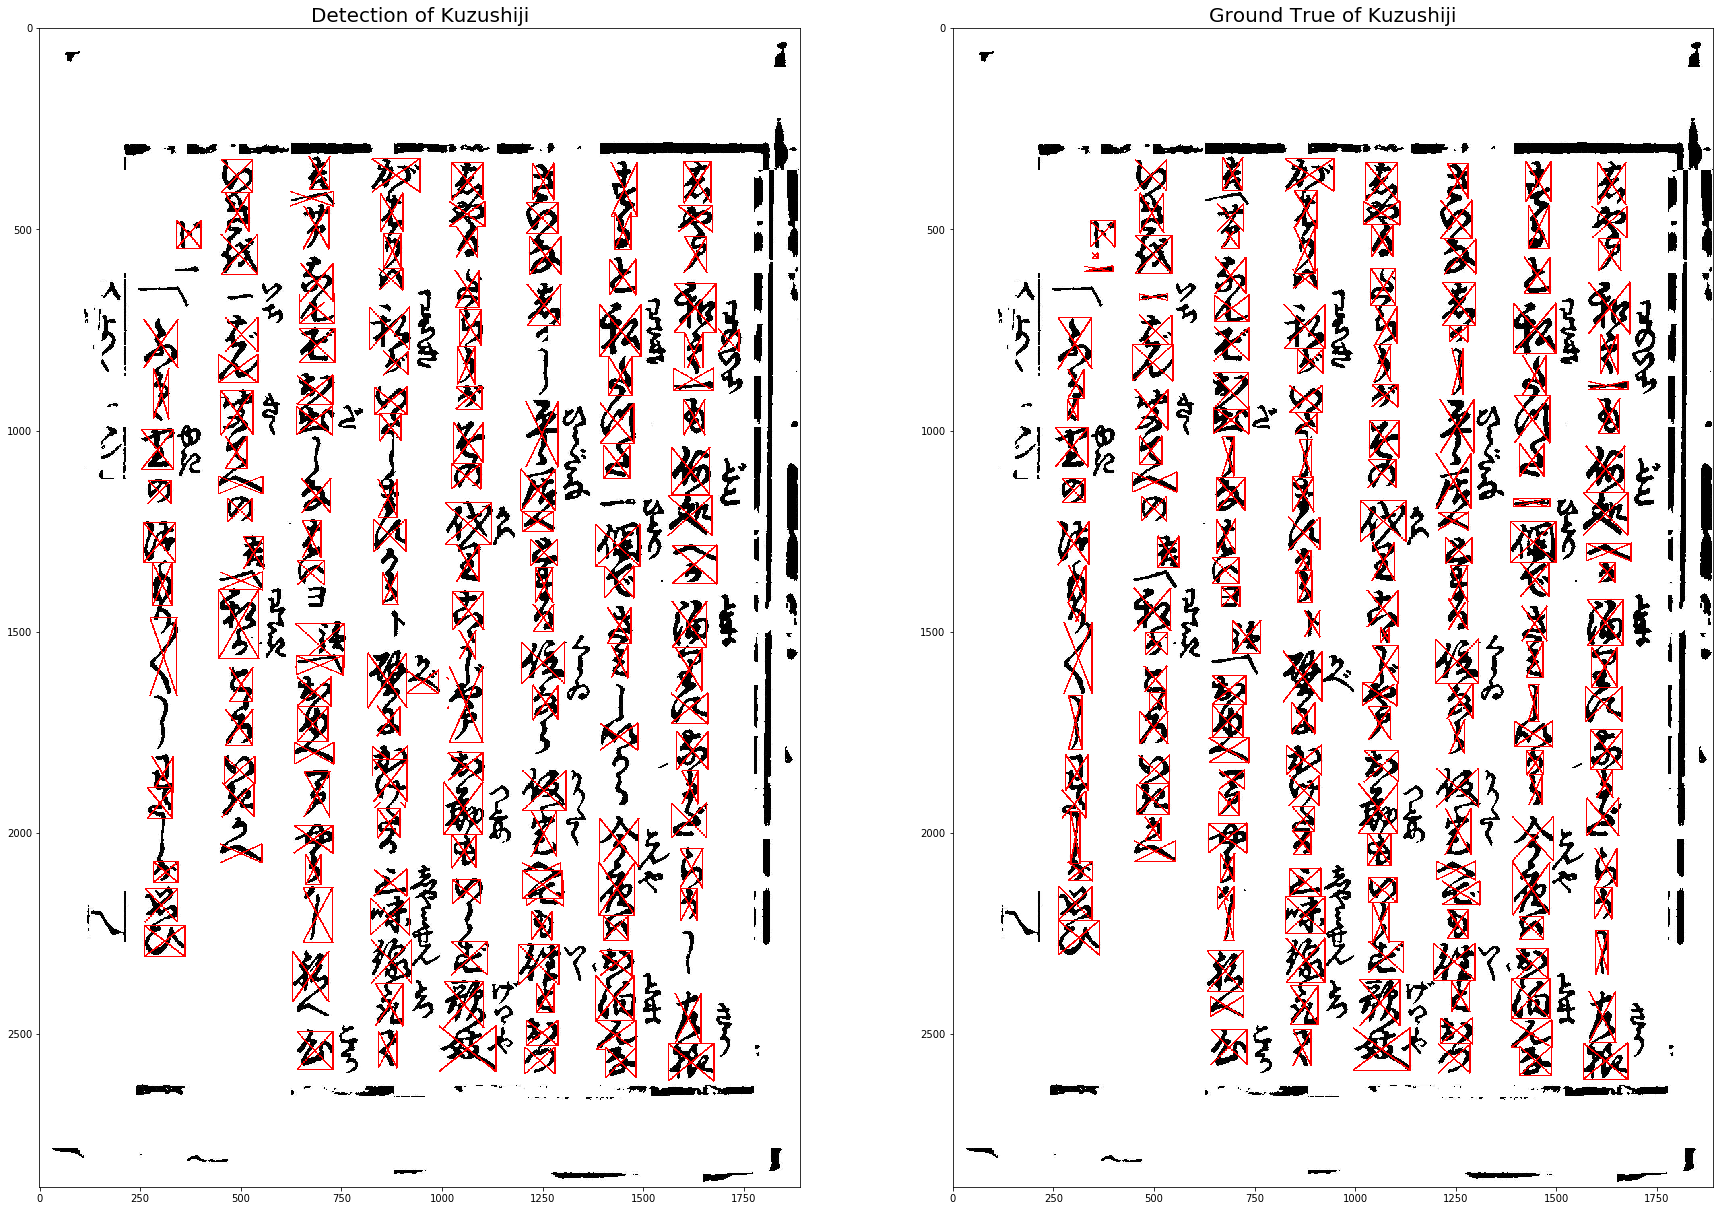

In [23]:
image_path='data/kuzushiji-recognition/'+file_names[4]

label = predict_to_label(image_path, model)
img_pred = visualize_training_data_hat(image_path, label)
labels_true = df_train.loc[df_train.image_id==image_path.split('/')[-1].split('.')[0], 'labels'].values[0]
img_true = visualize_training_data_hat(image_path, labels_true)

PlotVisualizeKuzushiji(img_true,img_pred)

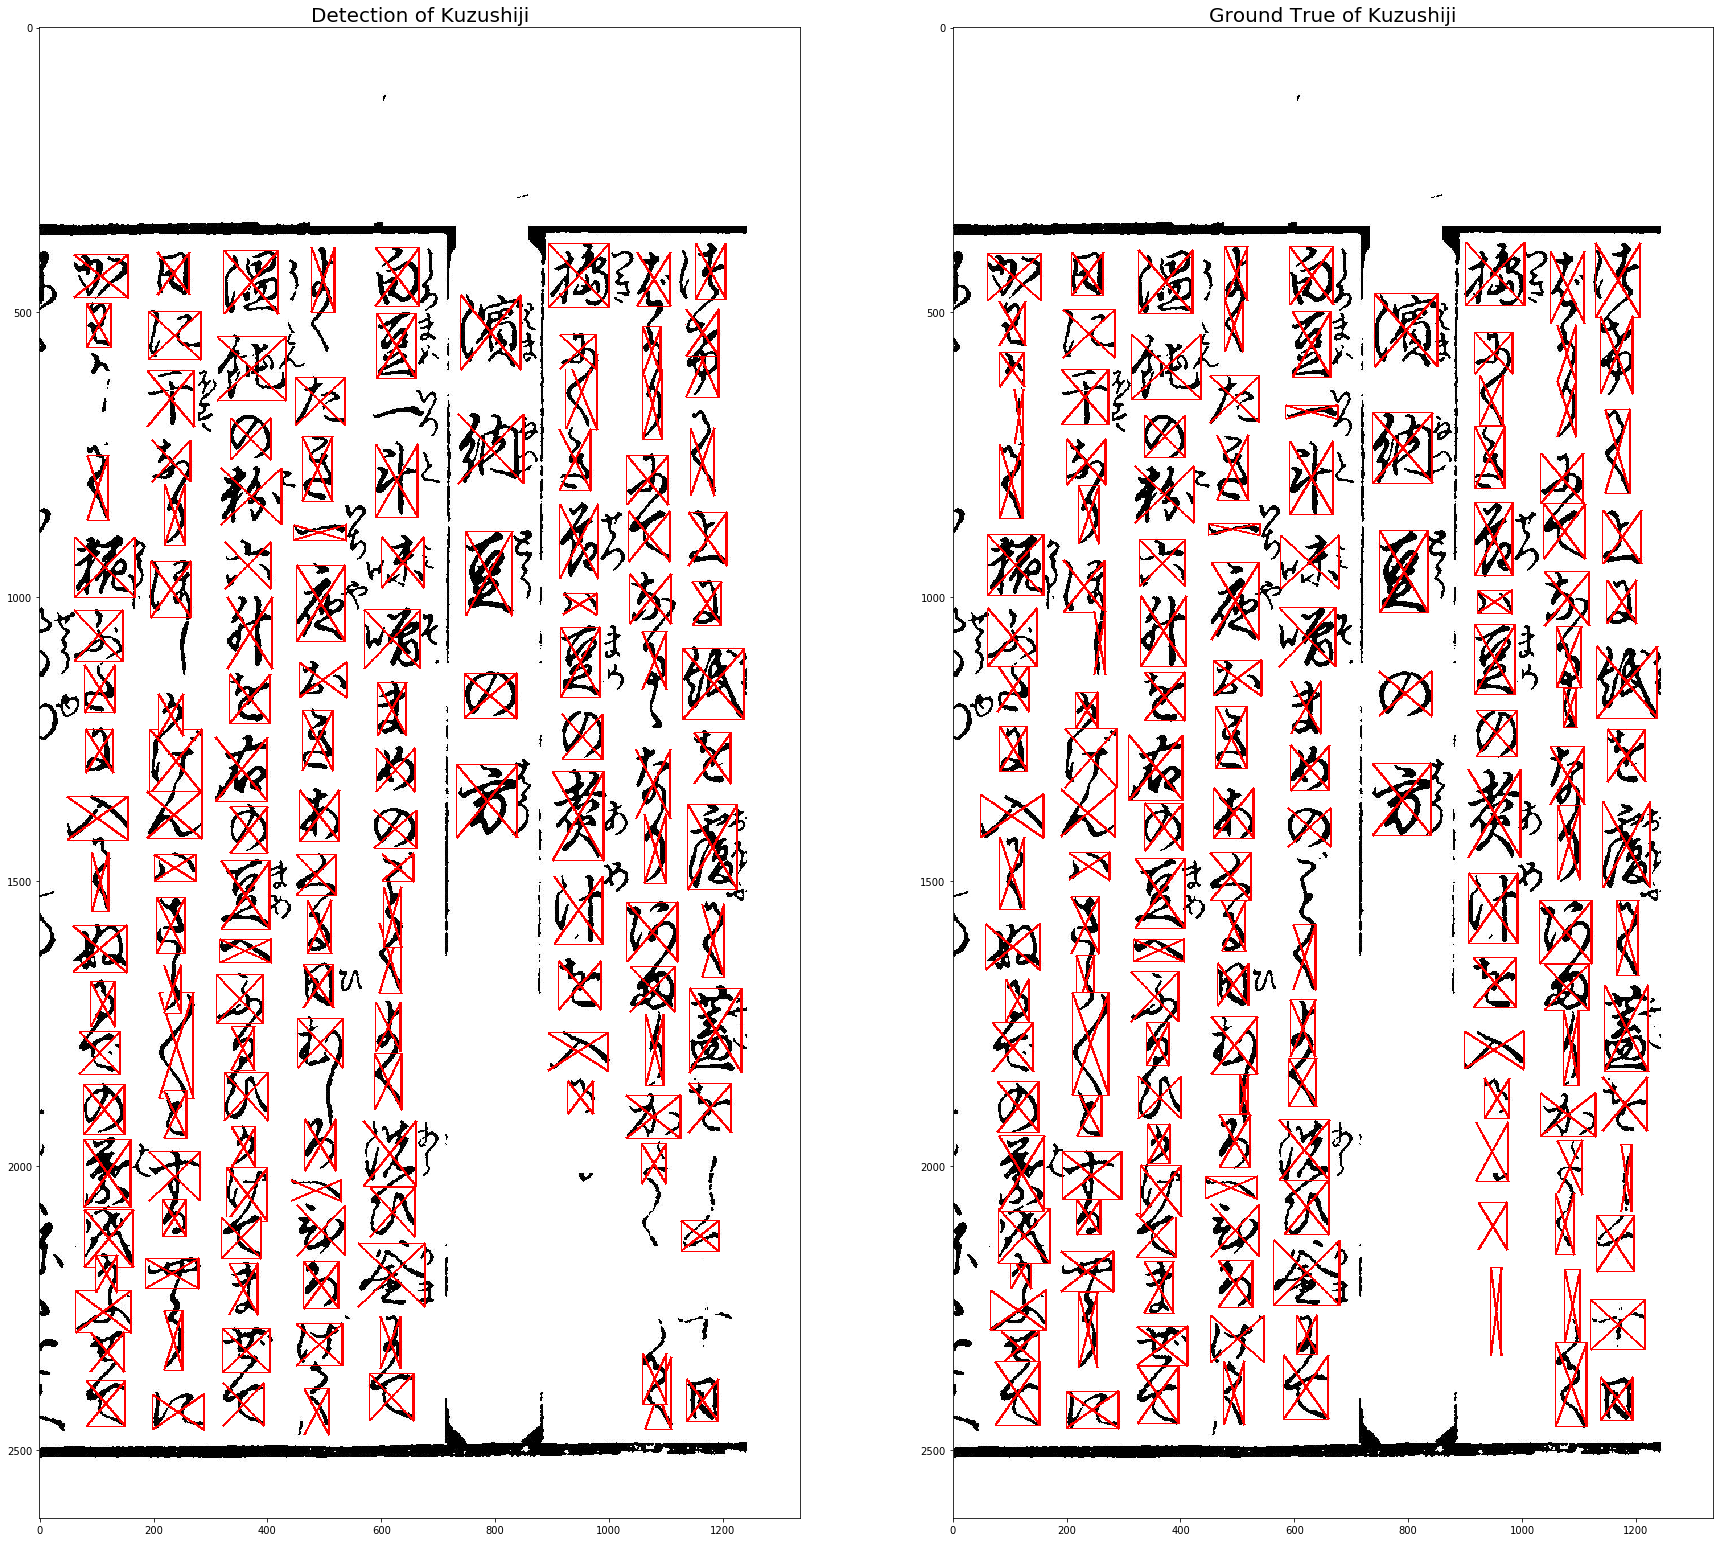

In [24]:
image_path='data/kuzushiji-recognition/'+file_names[16]

label = predict_to_label(image_path, model)
img_pred = visualize_training_data_hat(image_path, label)
labels_true = df_train.loc[df_train.image_id==image_path.split('/')[-1].split('.')[0], 'labels'].values[0]
img_true = visualize_training_data_hat(image_path, labels_true)

PlotVisualizeKuzushiji(img_true,img_pred)

In [21]:
#####################################################3

In [22]:
# # predict on every image & save data.
# from tqdm import tqdm

# all_boxes, all_scores, all_labels = None, None, None

# for file_name in tqdm(file_names):
#     boxes, scores, labels = predict_to_elements('data/kuzushiji-recognition/'+file_name, model)
#     if all_boxes is None:
#         all_boxes, all_scores, all_labels = boxes, scores, labels
#     else:
#         all_boxes = np.vstack((all_boxes,boxes))
#         all_scores = np.vstack((all_scores,scores))
#         all_labels = np.vstack((all_labels,labels))
        
# OUTPUT_DIR = './output/'        
# np.save('{}{}__all_boxes.npy'.format(OUTPUT_DIR, PREF), all_boxes)
# np.save('{}{}__all_scores.npy'.format(OUTPUT_DIR, PREF), all_scores)
# np.save('{}{}__all_labels.npy'.format(OUTPUT_DIR, PREF), all_labels)
# np.save('{}{}__file_names.npy'.format(OUTPUT_DIR, PREF), file_names)
        


In [23]:
## score to select best weigths

def iou_score(mask_true, mask_pred):
    y_pred = mask_true.flatten()
    y_true = mask_pred.flatten()

    intersection = np.sum(y_true*y_pred)
    union = np.sum(y_true)+np.sum(y_pred)-intersection

    return intersection/union

In [24]:
# Uncoment for check.
# threshold = 0.3

# IoUs = []
# for n in range(len(file_names)):
#     file_name = file_names[n].split('/')[-1].split('.')[0]
#     ann = df_train.loc[df_train.image_id==file_name, 'labels'].values[0]
#     ann = np.array(ann.split(' ')).reshape((-1,5))
#     boxes_true = []
#     for row in ann:
#         x1 = float(row[1])
#         x2 = float(row[1]) + float(row[3])/2
#         y1 = float(row[2])
#         y2 = float(row[2]) + float(row[4])/2
#         boxes_true.append((x1,y1,x2,y2))

#     image_path='data/kuzushiji-recognition/'+file_names[n]
#     size = Image.open(image_path).size

#     mask_true = np.zeros((size[1], size[0]))
#     mask_pred = np.zeros((size[1], size[0]))

#     for box in boxes_true:
#         mask_true[int(box[1]):int(box[3]),int(box[0]):int(box[2])] = 1

#     for num, box in enumerate(all_boxes[0]):
#         if all_scores[0][num] >= threshold:
#             mask_pred[int(box[1]):int(box[3]),int(box[0]):int(box[2])] = 1
            
#     IoUs.append(iou_score(mask_true, mask_pred))
    

# np.mean(IoUs)
    


In [25]:
thresholds = np.linspace(0.1,0.8,20)

def cacl_ious(file_names, threshold = 0.3, all_boxes=None, all_scores=None ):
    IoUs = []
    for n in range(len(file_names)):
        file_name = file_names[n].split('/')[-1].split('.')[0]
        ann = df_train.loc[df_train.image_id==file_name, 'labels'].values[0]
        ann = np.array(ann.split(' ')).reshape((-1,5))
        boxes_true = []
        for row in ann:
            x1 = float(row[1])
            x2 = float(row[1]) + float(row[3])/2
            y1 = float(row[2])
            y2 = float(row[2]) + float(row[4])/2
            boxes_true.append((x1,y1,x2,y2))

        image_path='data/kuzushiji-recognition/'+file_names[n]
        size = Image.open(image_path).size

        mask_true = np.zeros((size[1], size[0]))
        mask_pred = np.zeros((size[1], size[0]))

        for box in boxes_true:
            mask_true[int(box[1]):int(box[3]),int(box[0]):int(box[2])] = 1

        for num, box in enumerate(all_boxes[n]):
            if all_scores[n][num] >= threshold:
                mask_pred[int(box[1]):int(box[3]),int(box[0]):int(box[2])] = 1

        IoUs.append(iou_score(mask_true, mask_pred))
    return IoUs
    
# Uncomment for evaluate current model.
# for thr in thresholds:
#     IoUs = cacl_ious(file_names, thr, all_boxes=all_boxes, all_scores=all_scores )
#     print('thr: {}, mIoU: {}.'.format(thr, np.mean(IoUs)))



In [26]:
### Por unica vez evaluo cual es el mejor knowledge de la retinanet entrenada.


# predict on every image & save data.
def make_predictions(file_names, model, with_path=False):
    all_boxes, all_scores, all_labels = None, None, None

#     for file_name in tqdm(file_names):
    ct=0
    for file_name in tqdm(file_names):
        if with_path:
            boxes, scores, labels = predict_to_elements(file_name, model)
        else:
            boxes, scores, labels = predict_to_elements('data/kuzushiji-recognition/'+file_name, model)
            
        if all_boxes is None:
            all_boxes, all_scores, all_labels = boxes, scores, labels
        else:
            all_boxes = np.vstack((all_boxes,boxes))
            all_scores = np.vstack((all_scores,scores))
            all_labels = np.vstack((all_labels,labels))
        #if not ct % 10: print(str(ct), end=' . ')
        ct+=1
        
#     OUTPUT_DIR = './output/'        
#     np.save('{}{}__all_boxes.npy'.format(OUTPUT_DIR, PREF), all_boxes)
#     np.save('{}{}__all_scores.npy'.format(OUTPUT_DIR, PREF), all_scores)
#     np.save('{}{}__all_labels.npy'.format(OUTPUT_DIR, PREF), all_labels)
#     np.save('{}{}__file_names.npy'.format(OUTPUT_DIR, PREF), file_names)
    return all_boxes, all_scores, all_labels
        


In [32]:
from tqdm import tqdm

# Models already converted.
models_fn = ['resnet50_cvs_01.h5','resnet50_cvs_02.h5','resnet50_cvs_03.h5','resnet50_cvs_04.h5']
thresholds = np.linspace(0.1,0.8,8)

for model_filename in models_fn:
    print('- Working with {}.'.format(model_filename))
    # adjust this to point to your downloaded/trained model
    # models can be downloaded here: https://github.com/fizyr/keras-retinanet/releases
    model_path = os.path.join('.', 'converted_models', model_filename)

    # load retinanet model
    model = models.load_model(model_path, backbone_name='resnet50')


    all_boxes, all_scores, all_labels = make_predictions(file_names, model)

    for thr in thresholds:
        IoUs = cacl_ious(file_names, thr, all_boxes=all_boxes, all_scores=all_scores )
        print('    thr: {}, mIoU: {}.'.format(thr, np.mean(IoUs)))
    

- Working with resnet50_cvs_01.h5.


100%|██████████| 737/737 [20:44<00:00,  1.62s/it]


    thr: 0.1, mIoU: 0.20636148965010462.
    thr: 0.2, mIoU: 0.2154852631331866.
    thr: 0.30000000000000004, mIoU: 0.2186535231020665.
    thr: 0.4, mIoU: 0.22034685809905097.
    thr: 0.5, mIoU: 0.22095895659643303.
    thr: 0.6, mIoU: 0.22099809655697963.
    thr: 0.7000000000000001, mIoU: 0.22065627467525858.
    thr: 0.8, mIoU: 0.2193044879693274.
- Working with resnet50_cvs_02.h5.


100%|██████████| 737/737 [21:36<00:00,  1.75s/it]


    thr: 0.1, mIoU: 0.20508944807014612.
    thr: 0.2, mIoU: 0.21301402692196258.
    thr: 0.30000000000000004, mIoU: 0.2164256889134904.
    thr: 0.4, mIoU: 0.21787340125842053.
    thr: 0.5, mIoU: 0.21864316385333918.
    thr: 0.6, mIoU: 0.21848360268876862.
    thr: 0.7000000000000001, mIoU: 0.21766874477240283.
    thr: 0.8, mIoU: 0.21642094937327605.
- Working with resnet50_cvs_03.h5.


100%|██████████| 737/737 [21:13<00:00,  1.58s/it]


    thr: 0.1, mIoU: 0.20670933691382265.
    thr: 0.2, mIoU: 0.21564924552879666.
    thr: 0.30000000000000004, mIoU: 0.21893720395850585.
    thr: 0.4, mIoU: 0.22019864263140332.
    thr: 0.5, mIoU: 0.22051345411436202.
    thr: 0.6, mIoU: 0.22026169645494045.
    thr: 0.7000000000000001, mIoU: 0.2195837799248713.
    thr: 0.8, mIoU: 0.21771023475711063.
- Working with resnet50_cvs_04.h5.


100%|██████████| 737/737 [20:36<00:00,  1.68s/it]


    thr: 0.1, mIoU: 0.20781477916521035.
    thr: 0.2, mIoU: 0.2158333618144129.
    thr: 0.30000000000000004, mIoU: 0.2184929009534956.
    thr: 0.4, mIoU: 0.21964832395906053.
    thr: 0.5, mIoU: 0.22010019308020937.
    thr: 0.6, mIoU: 0.22014934304081038.
    thr: 0.7000000000000001, mIoU: 0.2196979467712587.
    thr: 0.8, mIoU: 0.21780866284465525.


In [27]:
# Prepare info for classifier.

In [26]:
from tqdm import tqdm

# Models already converted.
models_fn = ['resnet50_cvs_01.h5','resnet50_cvs_02.h5','resnet50_cvs_03.h5','resnet50_cvs_04.h5']
model_filename = models_fn[0]

thresholds = np.linspace(0.1,0.8,8)
thr = 0.575

print('- Working with {}.'.format(model_filename))
# adjust this to point to your downloaded/trained model
# models can be downloaded here: https://github.com/fizyr/keras-retinanet/releases
model_path = os.path.join('.', 'converted_models', model_filename)

# load retinanet model
model = models.load_model(model_path, backbone_name='resnet50')


all_boxes, all_scores, all_labels = make_predictions(file_names, model)

IoUs = cacl_ious(file_names, thr, all_boxes=all_boxes, all_scores=all_scores )
print('    thr: {}, mIoU: {}.'.format(thr, np.mean(IoUs)))
    

W0926 13:57:08.144150 139670073591552 deprecation_wrapper.py:119] From /home/maxim/.local/lib/python3.5/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0926 13:57:08.188383 139670073591552 deprecation_wrapper.py:119] From /home/maxim/.local/lib/python3.5/site-packages/keras/backend/tensorflow_backend.py:4115: The name tf.random_normal is deprecated. Please use tf.random.normal instead.

W0926 13:57:08.283948 139670073591552 deprecation_wrapper.py:119] From /home/maxim/.local/lib/python3.5/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0926 13:57:08.299504 139670073591552 deprecation_wrapper.py:119] From /home/maxim/.local/lib/python3.5/site-packages/keras/backend/tensorflow_backend.py:1919: The name tf.nn.fused_batch_norm is deprecated. Please use tf.compat.v1.nn.fused_batch_norm instead.

W0926 13:57:08.

- Working with resnet50_cvs_01.h5.


W0926 13:57:09.170072 139670073591552 deprecation_wrapper.py:119] From /home/maxim/Documents/keras-retinanet-master/keras_retinanet/backend/tensorflow_backend.py:68: The name tf.image.resize_images is deprecated. Please use tf.image.resize instead.

W0926 13:57:09.774311 139670073591552 deprecation.py:323] From /home/maxim/Documents/keras-retinanet-master/keras_retinanet/backend/tensorflow_backend.py:104: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0926 13:57:10.633108 139670073591552 deprecation_wrapper.py:119] From /home/maxim/.local/lib/python3.5/site-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.



In [ ]:
OUTPUT_DIR = './output/'        
np.save('{}{}__all_boxes.npy'.format(OUTPUT_DIR, PREF), all_boxes)
np.save('{}{}__all_scores.npy'.format(OUTPUT_DIR, PREF), all_scores)
np.save('{}{}__all_labels.npy'.format(OUTPUT_DIR, PREF), all_labels)
np.save('{}{}__file_names.npy'.format(OUTPUT_DIR, PREF), file_names)




In [34]:
all_boxes.shape

(737, 300, 4)

In [39]:
sub = pd.DataFrame({'image_id': ['BORRAR'], 'x1': [0], 'y1' : [0], 'x2' : [0], 'y2' : [0], 'score' : [0], 'set': ['val']})
sub.head()

,image_id,score,set,x1,x2,y1,y2
0,BORRAR,0,val,0,0,0,0


In [42]:
ct=0
sub = []
for file_name in tqdm(file_names):
    for box, score, pred_label in zip(all_boxes[ct], all_scores[ct], all_labels[ct]):
        b = box.astype(int)
        sub.append(pd.DataFrame({
            'image_id': [file_name], 
            'x1': [b[0]],
            'y1' : [b[1]],
            'x2' : [b[2]],
            'y2' : [b[3]], 
            'score' : [score], 
            'set': ['val']}))
    ct+=1

sub = pd.concat(sub)
sub.head()


 42%|████▏     | 309/737 [01:19<01:47,  3.97it/s]


 84%|████████▎ | 617/737 [02:38<00:30,  3.97it/s]


100%|██████████| 737/737 [03:09<00:00,  4.11it/s]

,image_id,score,set,x1,x2,y1,y2
0,images/200021853-00009_1.jpg,1.000000,val,412,529,471,584
0,images/200021853-00009_1.jpg,1.000000,val,856,968,1662,1746
0,images/200021853-00009_1.jpg,0.999999,val,498,596,1533,1636
0,images/200021853-00009_1.jpg,0.999988,val,860,951,1529,1652
0,images/200021853-00009_1.jpg,0.999982,val,21,145,821,914


In [43]:
sub.tail()

,image_id,score,set,x1,x2,y1,y2
0,images/hnsd007-029.jpg,0.087685,val,827,902,1373,1546
0,images/hnsd007-029.jpg,0.086135,val,1578,1680,452,549
0,images/hnsd007-029.jpg,0.086047,val,344,403,982,1057
0,images/hnsd007-029.jpg,0.085865,val,1396,1486,691,764
0,images/hnsd007-029.jpg,0.083661,val,727,783,614,701


In [28]:
df_train=pd.read_csv(TRAIN_DIR + 'train.csv')
df_train=df_train.dropna(axis=0, how='any')#you can use nan data(page with no letter)
df_train=df_train.reset_index(drop=True)
df_train.head() # En el nombre del archivo esta separado el libro_pagina_x x=1 es derecha, x=2 es izq. x=1 y x=2 tiene el mismo "fondo".


,image_id,labels
0,100241706_00004_2,U+306F 1231 3465 133 53 U+304C 275 1652 84 69 ...
1,100241706_00005_1,U+306F 1087 2018 103 65 U+304B 1456 1832 40 73...
2,100241706_00005_2,U+306F 572 1376 125 57 U+306E 1551 2080 69 68 ...
3,100241706_00006_1,U+3082 1455 3009 65 44 U+516B 1654 1528 141 75...
4,100241706_00007_2,U+309D 1201 2949 27 33 U+309D 1196 1539 27 36 ...


In [29]:
OUTPUT_DIR = './output/'
# sub.to_csv('{}{}__sub.csv'.format(OUTPUT_DIR,PREF), index=False)
test_df = df_train=pd.read_csv(TRAIN_DIR + 'sample_submission.csv')
test_df.head(16)

,image_id,labels
0,test_00145af3,U+003F 1 1 U+FF2F 2 2
1,test_001c37e2,U+003F 1 1 U+FF2F 2 2
2,test_003aa33a,U+003F 1 1 U+FF2F 2 2
3,test_00665e33,U+003F 1 1 U+FF2F 2 2
4,test_006964dc,U+003F 1 1 U+FF2F 2 2
5,test_0082d2cd,U+003F 1 1 U+FF2F 2 2
6,test_0086f578,U+003F 1 1 U+FF2F 2 2
7,test_008bc9f0,U+003F 1 1 U+FF2F 2 2
8,test_00912860,U+003F 1 1 U+FF2F 2 2
9,test_0095f51b,U+003F 1 1 U+FF2F 2 2


In [30]:
!ls ./output/

074a01a__all_boxes.npy	    074a01a__all_scores_ts.npy
074a01a__all_boxes_ts.npy   074a01a__file_names.npy
074a01a__all_labels.npy     074a01a__file_names_ts.npy
074a01a__all_labels_ts.npy  074a01a__sub.csv
074a01a__all_scores.npy


In [31]:
import glob

file_names = glob.glob('../kuzushiji-recognition/input/kuzushijibin/test_images/*.jpg')

file_names = [fn.split('/')[-1][:-4] for fn in file_names]


In [32]:
for fn in file_names:
    if fn not in test_df.image_id.values:
        print(fn)
print('-'*16)
for fn in test_df.image_id.values:
    if fn not in file_names:
        print(fn)


----------------


In [33]:
tqdm = None
# make predictions on test images
from tqdm import tqdm

# Models already converted.
models_fn = ['resnet50_cvs_01.h5','resnet50_cvs_02.h5','resnet50_cvs_03.h5','resnet50_cvs_04.h5']
model_filename = models_fn[0]

thresholds = np.linspace(0.1,0.8,8)
thr = 0.575

file_names = glob.glob('../kuzushiji-recognition/input/kuzushijibin/test_images/*.jpg')

print('- Working with {}.'.format(model_filename))
# adjust this to point to your downloaded/trained model
# models can be downloaded here: https://github.com/fizyr/keras-retinanet/releases
model_path = os.path.join('.', 'converted_models', model_filename)

# load retinanet model
model = models.load_model(model_path, backbone_name='resnet50')


all_boxes, all_scores, all_labels = make_predictions(file_names, model, with_path=True)

# IoUs = cacl_ious(file_names, thr, all_boxes=all_boxes, all_scores=all_scores )
# print('    thr: {}, mIoU: {}.'.format(thr, np.mean(IoUs)))


W0926 19:00:07.803578 139715384084224 deprecation_wrapper.py:119] From /home/maxim/.local/lib/python3.5/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0926 19:00:07.855689 139715384084224 deprecation_wrapper.py:119] From /home/maxim/.local/lib/python3.5/site-packages/keras/backend/tensorflow_backend.py:4115: The name tf.random_normal is deprecated. Please use tf.random.normal instead.

W0926 19:00:07.953322 139715384084224 deprecation_wrapper.py:119] From /home/maxim/.local/lib/python3.5/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0926 19:00:07.968471 139715384084224 deprecation_wrapper.py:119] From /home/maxim/.local/lib/python3.5/site-packages/keras/backend/tensorflow_backend.py:1919: The name tf.nn.fused_batch_norm is deprecated. Please use tf.compat.v1.nn.fused_batch_norm instead.

W0926 19:00:07.

- Working with resnet50_cvs_01.h5.


W0926 19:00:08.842753 139715384084224 deprecation_wrapper.py:119] From /home/maxim/Documents/keras-retinanet-master/keras_retinanet/backend/tensorflow_backend.py:68: The name tf.image.resize_images is deprecated. Please use tf.image.resize instead.

W0926 19:00:09.471974 139715384084224 deprecation.py:323] From /home/maxim/Documents/keras-retinanet-master/keras_retinanet/backend/tensorflow_backend.py:104: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0926 19:00:10.362302 139715384084224 deprecation_wrapper.py:119] From /home/maxim/.local/lib/python3.5/site-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

100%|██████████| 4150/4150 [1:53:51<00:00,  1.65s/it]  


In [35]:
OUTPUT_DIR = './output/'        
np.save('{}{}__all_boxes_ts.npy'.format(OUTPUT_DIR, PREF), all_boxes)
np.save('{}{}__all_scores_ts.npy'.format(OUTPUT_DIR, PREF), all_scores)
np.save('{}{}__all_labels_ts.npy'.format(OUTPUT_DIR, PREF), all_labels)
np.save('{}{}__file_names_ts.npy'.format(OUTPUT_DIR, PREF), file_names)


In [ ]:
# from importlib import reload

# ct=0
# sub_hat = []
# for file_name in tqdm(file_names):
#     for box, score, pred_label in zip(all_boxes[ct], all_scores[ct], all_labels[ct]):
#         b = box.astype(int)
#         sub_hat.append(pd.DataFrame({
#             'image_id': [file_name], 
#             'x1': [b[0]],
#             'y1' : [b[1]],
#             'x2' : [b[2]],
#             'y2' : [b[3]], 
#             'score' : [score], 
#             'set': ['test']}))
#     ct+=1

# sub_hat = pd.concat(sub_hat)

# sub_hat.head()

100%|██████████| 4150/4150 [17:18<00:00,  4.10it/s]


In [ ]:
# ct=0
# sub_hat = []
# for file_name in tqdm(file_names):
#     for box, score, pred_label in zip(all_boxes[ct], all_scores[ct], all_labels[ct]):
#         b = box.astype(int)
#         sub_hat.append(pd.DataFrame({
#             'image_id': [file_name], 
#             'x1': [b[0]],
#             'y1' : [b[1]],
#             'x2' : [b[2]],
#             'y2' : [b[3]], 
#             'score' : [score], 
#             'set': ['test']}))
#     ct+=1

# sub_hat = pd.concat(sub_hat)

# sub_hat.head()

In [61]:
n,step, 

(2000, 1000, 2)

In [ ]:
sub_hat.to_csv('{}{}__sub_ts.csv'.format(OUTPUT_DIR,PREF), index=False)

In [77]:
step = 1000
for n in range(0, len(file_names), step):
    ct = 0
    sub_hat = []
    last_pos = min(n+step, len(file_names))
    for file_name in file_names[n:last_pos]:
        for box, score, pred_label in zip(all_boxes[ct], all_scores[ct], all_labels[ct]):
            b = box.astype(int)
            sub_hat.append(pd.DataFrame({
                'image_id': [file_name], 
                'x1': [b[0]],
                'y1' : [b[1]],
                'x2' : [b[2]],
                'y2' : [b[3]], 
                'score' : [score], 
                'set': ['test']}))
        ct+=1
    sub_hat = pd.concat(sub_hat)
    print(n // step, end=' . ')
    sub_hat.to_csv('{}{}__sub_ts_{}.csv'.format(OUTPUT_DIR, PREF, n // step), index=False)
    


0 . 1 . 2 . 3 . 4 . 

In [78]:
len(file_names)

4150

In [79]:
sub_hat.head(10)

,image_id,score,set,x1,x2,y1,y2
0,../kuzushiji-recognition/input/kuzushijibin/te...,-1.0,test,-2,-2,-2,-2
0,../kuzushiji-recognition/input/kuzushijibin/te...,-1.0,test,-2,-2,-2,-2
0,../kuzushiji-recognition/input/kuzushijibin/te...,-1.0,test,-2,-2,-2,-2
0,../kuzushiji-recognition/input/kuzushijibin/te...,-1.0,test,-2,-2,-2,-2
0,../kuzushiji-recognition/input/kuzushijibin/te...,-1.0,test,-2,-2,-2,-2
0,../kuzushiji-recognition/input/kuzushijibin/te...,-1.0,test,-2,-2,-2,-2
0,../kuzushiji-recognition/input/kuzushijibin/te...,-1.0,test,-2,-2,-2,-2
0,../kuzushiji-recognition/input/kuzushijibin/te...,-1.0,test,-2,-2,-2,-2
0,../kuzushiji-recognition/input/kuzushijibin/te...,-1.0,test,-2,-2,-2,-2
0,../kuzushiji-recognition/input/kuzushijibin/te...,-1.0,test,-2,-2,-2,-2


In [80]:
sub_hat.tail(10)

,image_id,score,set,x1,x2,y1,y2
0,../kuzushiji-recognition/input/kuzushijibin/te...,0.220171,test,1624,1718,857,917
0,../kuzushiji-recognition/input/kuzushijibin/te...,0.219776,test,1776,1872,2607,2728
0,../kuzushiji-recognition/input/kuzushijibin/te...,0.217947,test,348,395,2279,2351
0,../kuzushiji-recognition/input/kuzushijibin/te...,0.216519,test,976,1071,1475,1657
0,../kuzushiji-recognition/input/kuzushijibin/te...,0.209261,test,1939,2027,1602,1705
0,../kuzushiji-recognition/input/kuzushijibin/te...,0.206465,test,641,758,693,816
0,../kuzushiji-recognition/input/kuzushijibin/te...,0.199619,test,498,579,641,727
0,../kuzushiji-recognition/input/kuzushijibin/te...,0.198143,test,1622,1718,714,828
0,../kuzushiji-recognition/input/kuzushijibin/te...,0.196930,test,1129,1232,628,778
0,../kuzushiji-recognition/input/kuzushijibin/te...,0.196072,test,1498,1551,485,622


In [81]:
sub_hat.iloc[0,0],sub_hat.iloc[299,0],sub_hat.iloc[300,0]

('../kuzushiji-recognition/input/kuzushijibin/test_images/test_08f99dc6.jpg',
 '../kuzushiji-recognition/input/kuzushijibin/test_images/test_08f99dc6.jpg',
 '../kuzushiji-recognition/input/kuzushijibin/test_images/test_f26d335d.jpg')

In [82]:
sub_hat.iloc[300:320]

,image_id,score,set,x1,x2,y1,y2
0,../kuzushiji-recognition/input/kuzushijibin/te...,0.999838,test,171,265,1314,1408
0,../kuzushiji-recognition/input/kuzushijibin/te...,0.999804,test,1546,1646,1482,1571
0,../kuzushiji-recognition/input/kuzushijibin/te...,0.999737,test,1538,1633,2273,2395
0,../kuzushiji-recognition/input/kuzushijibin/te...,0.999685,test,183,269,1709,1807
0,../kuzushiji-recognition/input/kuzushijibin/te...,0.999676,test,367,457,459,600
0,../kuzushiji-recognition/input/kuzushijibin/te...,0.999546,test,1732,1826,649,760
0,../kuzushiji-recognition/input/kuzushijibin/te...,0.999539,test,1355,1446,2573,2690
0,../kuzushiji-recognition/input/kuzushijibin/te...,0.999516,test,562,655,1292,1374
0,../kuzushiji-recognition/input/kuzushijibin/te...,0.999513,test,177,271,2771,2908
0,../kuzushiji-recognition/input/kuzushijibin/te...,0.999435,test,173,266,1596,1701


In [83]:
all_scores.shape

(4150, 300)

In [84]:
all_scores[1]

array([0.9998375 , 0.9998041 , 0.9997368 , 0.99968505, 0.9996762 ,
       0.9995456 , 0.99953914, 0.9995159 , 0.9995126 , 0.99943495,
       0.99938416, 0.99935853, 0.9992366 , 0.9991101 , 0.9990668 ,
       0.9989606 , 0.99884236, 0.99882454, 0.99869955, 0.9986401 ,
       0.99851424, 0.99839723, 0.9981195 , 0.9980922 , 0.99786985,
       0.9978075 , 0.9977977 , 0.99772936, 0.9972689 , 0.9971762 ,
       0.99705815, 0.9967203 , 0.99653894, 0.996492  , 0.99637586,
       0.995431  , 0.99509823, 0.99490607, 0.9947834 , 0.99474955,
       0.99435884, 0.9942943 , 0.9937539 , 0.9935518 , 0.99240494,
       0.99228734, 0.99218893, 0.9920564 , 0.99163395, 0.99141866,
       0.9912715 , 0.99098474, 0.9909714 , 0.99091434, 0.99082637,
       0.99013764, 0.9895162 , 0.98915255, 0.9887143 , 0.9885278 ,
       0.98787   , 0.9877923 , 0.98770016, 0.9876684 , 0.98759013,
       0.98730284, 0.98720443, 0.9866749 , 0.98594725, 0.98577493,
       0.9855944 , 0.98516303, 0.98506236, 0.98414576, 0.98402

In [ ]:
# EOF >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


In [ ]:
# current = confusion_matrix(y_true, y_pred, labels=[0, 1])

# # compute mean iou
# intersection = np.diag(current)
# ground_truth_set = current.sum(axis=1)
# predicted_set = current.sum(axis=0)
# union = ground_truth_set + predicted_set - intersection
# IoU = intersection / union.astype(np.float32)
# IoU = np.mean(IoU)

In [ ]:
def predict_to_label(image_path, model):
    # load image
    image = read_image_bgr(image_path)

    # preprocess image for network
    image = preprocess_image(image)
    image, scale = resize_image(image)

    boxes, scores, labels = model.predict_on_batch(np.expand_dims(image, axis=0))

    # correct for image scale
    boxes /= scale

    # compose label
    label = ''
    for box, score, pred_label in zip(boxes[0], scores[0], labels[0]):
        # scores are sorted so we can break
        if score < 0.5:
            break

        try:
            label += labels_to_names[pred_label] + ' '
        except:
            print(labels_to_names[label])
        b = box.astype(int)
        label += '{} {} {} {} '.format(str(b[0]),str(b[1]),str(b[2]-b[0]),str(b[3]-b[1]))

    if len(label)>4:
        label = label[:-1]
        
    return label


In [ ]:
predict_to_label('data/kuzushiji-recognition/images/100241706_00005_1.jpg', model)

In [ ]:
# import keras_retinanet
from keras_retinanet import models
from keras_retinanet.utils.image import read_image_bgr, preprocess_image, resize_image
from keras_retinanet.utils.visualization import draw_box, draw_caption
from keras_retinanet.utils.colors import label_color


labels_to_names = {0:'.'}

# load image
image = read_image_bgr('data/kuzushiji-recognition/images/100241706_00005_1.jpg')

# copy to draw on
draw = image.copy()
draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)

# preprocess image for network
image = preprocess_image(image)
image, scale = resize_image(image)

# process image
start = time.time()
boxes, scores, labels = model.predict_on_batch(np.expand_dims(image, axis=0))
print("processing time: ", time.time() - start)

# correct for image scale
boxes /= scale

# visualize detections
for box, score, label in zip(boxes[0], scores[0], labels[0]):
    # scores are sorted so we can break
    if score < 0.5:
        break
        
    color = label_color(label)
    
    b = box.astype(int)
    draw_box(draw, b, color=color)
    
    caption = "{} {:.3f}".format(labels_to_names[label], score)
    draw_caption(draw, b, caption)
    break
    
plt.figure(figsize=(15, 15))
plt.axis('off')
plt.imshow(draw)
plt.show()


In [ ]:
b

In [ ]:
boxes, scores, labels

In [ ]:
boxes.shape, scores.shape, labels.shape, image.shape

In [ ]:
boxes[0,0], scores[0,0], labels[0,0]

In [ ]:
boxes[0,0]*scale

In [ ]:
from PIL import Image, ImageDraw, ImageFont, ImageOps


# This function takes in a filename of an image, and the labels in the string format given in train.csv, and returns an image containing the bounding boxes
def visualize_training_data_hat(image_fn, labels):
    # Convert annotation string to array
    fontsize = 12
    labels = np.array(labels.split(' ')).reshape(-1, 5)
    
    # Read image
    imsource = Image.open(image_fn).convert('RGBA')
    bbox_canvas = Image.new('RGBA', imsource.size)
    char_canvas = Image.new('RGBA', imsource.size)
    bbox_draw = ImageDraw.Draw(bbox_canvas) # Separate canvases for boxes and chars so a box doesn't cut off a character
    char_draw = ImageDraw.Draw(char_canvas)

    for codepoint, x, y, w, h in labels:
        x, y, w, h = int(x), int(y), int(w), int(h)
        #char = unicode_map[codepoint] # Convert codepoint to actual unicode character
        char = codepoint

        # Draw bounding box around character, and unicode character next to it
        bbox_draw.rectangle((x, y, x+w, y+h), fill=(255, 255, 255, 0), outline=(255, 0, 0, 255))
        bbox_draw.line([(x,y),(x+w,y+h),(x+w,y),(x,y+h)], fill=(255, 0, 0), width=4)
        #char_draw.text((x + w + fontsize/4, y + h/2 - fontsize), char, fill=(0, 0, 255, 255), font=font)

    imsource = Image.alpha_composite(Image.alpha_composite(imsource, bbox_canvas), char_canvas)
    imsource = imsource.convert("RGB") # Remove alpha for saving in jpg format.
    return imsource

In [ ]:
def PlotVisualizeKuzushiji(image_file):
    img1, imsource1, rects_hat = VisualizeKuzushiji_hat(image_file)
    plt.figure(figsize=(30,30))
    plt.subplot(1,2,1)
    plt.title("Detection of Kuzushiji",fontsize=20)
    plt.imshow(img1)
    plt.subplot(1,2,2)
    plt.title("Ground True of Kuzushiji",fontsize=20)
    #plt.imshow(imsource1)
    fn = image_file.split('/')[-1][:-4]
    label = df_train.loc[df_train['image_id']==fn,'labels'].values[0]
    img = visualize_training_data_hat(image_file, label)    
    plt.imshow(img)
    plt.show()
    
    return rects_hat

def PlotVisualizeKuzushiji(img_true, img_pred):
    plt.figure(figsize=(30,30))
    plt.subplot(1,2,1)
    plt.title("Detection of Kuzushiji",fontsize=20)
    plt.imshow(img_pred)
    plt.subplot(1,2,2)
    plt.title("Ground True of Kuzushiji",fontsize=20)
    plt.imshow(img_true)
#     fn = image_file.split('/')[-1][:-4]
#     label = df_train.loc[df_train['image_id']==fn,'labels'].values[0]
#     img = visualize_training_data_hat(image_file, label)    
#     plt.imshow(img)
    plt.show()
    


In [ ]:
labels_true = df_train.loc[df_train.image_id=='100241706_00005_1', 'labels'].values[0]

In [ ]:
image_path='data/kuzushiji-recognition/images/100241706_00005_1.jpg'

label = predict_to_label(image_path, model)
img_pred = visualize_training_data_hat(image_path, label)
img_true = visualize_training_data_hat(image_path, labels_true)

PlotVisualizeKuzushiji(img_true,img_pred)

In [ ]:
image_path='data/kuzushiji-recognition/images/100241706_00012_2.jpg'

labels_true = df_train.loc[df_train.image_id=='100241706_00012_2', 'labels'].values[0]

label = predict_to_label(image_path, model)
img_pred = visualize_training_data_hat(image_path, label)
img_true = visualize_training_data_hat(image_path, labels_true)

PlotVisualizeKuzushiji(img_true,img_pred)

In [ ]:
TRAIN_DIR='../kuzushiji-recognition/input/kuzushiji-recognition/'


In [ ]:
!ls '../kuzushiji-recognition/input/kuzushiji-recognition/train_images/100241706_00012_2.jpg'

In [ ]:
image_path='../kuzushiji-recognition/input/kuzushiji-recognition/train_images/100241706_00012_2.jpg'

label = predict_to_label(image_path, model)
img_pred = visualize_training_data_hat(image_path, label)
img_true = visualize_training_data_hat(image_path, labels_true)

PlotVisualizeKuzushiji(img_true,img_pred)

In [ ]:
def makedirs(path):
    # Intended behavior: try to create the directory,
    # pass if the directory exists already, fails otherwise.
    # Meant for Python 2.7/3.n compatibility.
    try:
        os.makedirs(path)
    except OSError:
        if not os.path.isdir(path):
            raise


def get_session():
    """ Construct a modified tf session.
    """
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    return tf.Session(config=config)


def model_with_weights(model, weights, skip_mismatch):
    """ Load weights for model.

    Args
        model         : The model to load weights for.
        weights       : The weights to load.
        skip_mismatch : If True, skips layers whose shape of weights doesn't match with the model.
    """
    if weights is not None:
        model.load_weights(weights, by_name=True, skip_mismatch=skip_mismatch)
    return model




In [ ]:
def create_models(backbone_retinanet, num_classes, weights, multi_gpu=0,
                  freeze_backbone=False, lr=1e-5, config=None):
    """ Creates three models (model, training_model, prediction_model).

    Args
        backbone_retinanet : A function to call to create a retinanet model with a given backbone.
        num_classes        : The number of classes to train.
        weights            : The weights to load into the model.
        multi_gpu          : The number of GPUs to use for training.
        freeze_backbone    : If True, disables learning for the backbone.
        config             : Config parameters, None indicates the default configuration.

    Returns
        model            : The base model. This is also the model that is saved in snapshots.
        training_model   : The training model. If multi_gpu=0, this is identical to model.
        prediction_model : The model wrapped with utility functions to perform object detection (applies regression values and performs NMS).
    """

    modifier = freeze_model if freeze_backbone else None

    # load anchor parameters, or pass None (so that defaults will be used)
    anchor_params = None
    num_anchors   = None
    if config and 'anchor_parameters' in config:
        anchor_params = parse_anchor_parameters(config)
        num_anchors   = anchor_params.num_anchors()

    # Keras recommends initialising a multi-gpu model on the CPU to ease weight sharing, and to prevent OOM errors.
    # optionally wrap in a parallel model
    if multi_gpu > 1:
        from keras.utils import multi_gpu_model
        with tf.device('/cpu:0'):
            model = model_with_weights(backbone_retinanet(num_classes, num_anchors=num_anchors, modifier=modifier), weights=weights, skip_mismatch=True)
        training_model = multi_gpu_model(model, gpus=multi_gpu)
    else:
        model          = model_with_weights(backbone_retinanet(num_classes, num_anchors=num_anchors, modifier=modifier), weights=weights, skip_mismatch=True)
        training_model = model

    # make prediction model
    prediction_model = retinanet_bbox(model=model, anchor_params=anchor_params)

    # compile model
    training_model.compile(
        loss={
            'regression'    : losses.smooth_l1(),
            'classification': losses.focal()
        },
        optimizer=keras.optimizers.adam(lr=lr, clipnorm=0.001)
    )

    return model, training_model, prediction_model




In [ ]:
def create_callbacks(model, training_model, prediction_model, validation_generator, 
    tensorboard_dir='./logs', 
    batch_size=1, 
    evaluation=True,
    snapshots=True,
    snapshot_path='./snapshot',
    backbone_name='resnet50',
    dataset_type='cvs'):
    """ Creates the callbacks to use during training.

    Args
        model: The base model.
        training_model: The model that is used for training.
        prediction_model: The model that should be used for validation.
        validation_generator: The generator for creating validation data.
        args: parseargs args object.

    Returns:
        A list of callbacks used for training.
    """
    callbacks = []

    tensorboard_callback = None

    if tensorboard_dir is not None:
        tensorboard_callback = keras.callbacks.TensorBoard(
            log_dir                = tensorboard_dir,
            histogram_freq         = 0,
            batch_size             = batch_size,
            write_graph            = True,
            write_grads            = False,
            write_images           = False,
            embeddings_freq        = 0,
            embeddings_layer_names = None,
            embeddings_metadata    = None
        )
        callbacks.append(tensorboard_callback)

    if evaluation and validation_generator:
        evaluation = Evaluate(validation_generator, tensorboard=tensorboard_callback, weighted_average=args.weighted_average)
        evaluation = RedirectModel(evaluation, prediction_model)
        callbacks.append(evaluation)

    # save the model
    if snapshots:
        # ensure directory created first; otherwise h5py will error after epoch. 
        makedirs(snapshot_path)
        checkpoint = keras.callbacks.ModelCheckpoint(
            os.path.join(
                snapshot_path,
                '{backbone}_{dataset_type}_{{epoch:02d}}.h5'.format(backbone=backbone_name, dataset_type=dataset_type)
            ),
            verbose=1,
            # save_best_only=True,
            # monitor="mAP",
            # mode='max'
        )
        checkpoint = RedirectModel(checkpoint, model)
        callbacks.append(checkpoint)

    callbacks.append(keras.callbacks.ReduceLROnPlateau(
        monitor    = 'loss',
        factor     = 0.1,
        patience   = 2,
        verbose    = 1,
        mode       = 'auto',
        min_delta  = 0.0001,
        cooldown   = 0,
        min_lr     = 0
    ))

    return callbacks


In [ ]:
def create_generators(preprocess_image, batch_size=1, image_min_side=640, image_max_side=1000,
    train_annotations='./data/kuzushiji-recognition/060a01d_train.txt',
    train_classes='./data/kuzushiji-recognition/060a01d__kuzushiji.labels',
    val_annotations='./data/kuzushiji-recognition/060a01d_test.txt'):
    """ Create generators for training and validation.

    Args
        args             : parseargs object containing configuration for generators.
        preprocess_image : Function that preprocesses an image for the network.
    """
    common_args = {
        'batch_size'       : batch_size,
        #'config'           : args.config,
        'image_min_side'   : image_min_side,
        'image_max_side'   : image_max_side,
        'preprocess_image' : preprocess_image,
    }

    # create random transform generator for augmenting training data
    if False: #args.random_transform:
        transform_generator = random_transform_generator(
            min_rotation=-0.1,
            max_rotation=0.1,
            min_translation=(-0.1, -0.1),
            max_translation=(0.1, 0.1),
            min_shear=-0.1,
            max_shear=0.1,
            min_scaling=(0.9, 0.9),
            max_scaling=(1.1, 1.1),
            flip_x_chance=0.5,
            flip_y_chance=0.5,
        )
        visual_effect_generator = random_visual_effect_generator(
            contrast_range=(0.9, 1.1),
            brightness_range=(-.1, .1),
            hue_range=(-0.05, 0.05),
            saturation_range=(0.95, 1.05)
        )
    else:
        transform_generator = random_transform_generator(flip_x_chance=0.5)
        visual_effect_generator = None

    # Dataset type 'csv':
    train_generator = CSVGenerator(
        train_annotations,
        train_classes,
        transform_generator=transform_generator,
        visual_effect_generator=visual_effect_generator,
        **common_args
    )

    if val_annotations is not None:
        validation_generator = CSVGenerator(
            val_annotations,
            train_classes,
            shuffle_groups=False,
            **common_args
        )
    else:
        validation_generator = None
    return train_generator, validation_generator


In [ ]:
#args = "-u keras_retinanet/bin/train.py --image-min-side 640 --image-max-side 1000 --weights ./snapshots/resnet50_csv_05.h5 csv ./data/kuzushiji-recognition/060a01d_train.txt ./data/kuzushiji-recognition/060a01d__kuzushiji.labels --val-annotations ./data/kuzushiji-recognition/060a01d_test.txt"
backbone_name='resnet50'
snapshot = './snapshots/resnet50_csv_05.h5'
weights = None
multi_gpu = 0
#
epochs=50
batch_size=1
steps=3600
snapshot_path='./snapshots'
tensorboard_dir='./logs'
no_snapshots=False
no_evaluation=False
freeze_backbone=False  ##
random_transform=True
#config='../*.ini'
weighted_average=True
compute_val_loss=True
multiprocessing=True
workers=1
max_queue_size=10
lr = 1e-5

# create object that stores backbone information
backbone = models.backbone(backbone_name)

# make sure keras is the minimum required version
check_keras_version()

# optionally choose specific GPU
if COLAB:
    os.environ['CUDA_VISIBLE_DEVICES'] = '0'
else:
    os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
keras.backend.tensorflow_backend.set_session(get_session())

# create the generators
train_generator, validation_generator = create_generators(backbone.preprocess_image)

# create the model
if snapshot is not None:
    print('Loading model, this may take a second...')
    model            = models.load_model(snapshot, backbone_name=backbone_name)
    training_model   = model
    anchor_params    = None
    prediction_model = retinanet_bbox(model=model, anchor_params=anchor_params)
else:
    weights = weights
    # default to imagenet if nothing else is specified
    if weights is None and args.imagenet_weights:
        weights = backbone.download_imagenet()

    print('Creating model, this may take a second...')
    model, training_model, prediction_model = create_models(
        backbone_retinanet=backbone.retinanet,
        num_classes=train_generator.num_classes(),
        weights=weights,
        multi_gpu=multi_gpu,
        freeze_backbone=freeze_backbone,
        lr=lr,
        config=args.config
    )

# print model summary
print(model.summary())

# this lets the generator compute backbone layer shapes using the actual backbone model
if 'vgg' in backbone_name or 'densenet' in backbone_name:
    train_generator.compute_shapes = make_shapes_callback(model)
    if validation_generator:
        validation_generator.compute_shapes = train_generator.compute_shapes

# create the callbacks
callbacks = create_callbacks(
    model,
    training_model,
    prediction_model,
    validation_generator,
    
    tensorboard_dir=tensorboard_dir, 
    batch_size=batch_size, 
    evaluation=not no_evaluation,
    snapshots=not no_snapshots,
    snapshot_path=snapshot_path,
    backbone_name=backbone_name,
    dataset_type='cvs'
)

if not compute_val_loss:
    validation_generator = None

# start training
history = training_model.fit_generator(
    generator=train_generator,
    steps_per_epoch=steps,
    epochs=epochs,
    verbose=1,
    callbacks=callbacks,
    workers=workers,
    use_multiprocessing=multiprocessing,
    max_queue_size=max_queue_size,
    validation_data=validation_generator
)


In [ ]:
tic_tac(False)

In [ ]:
# EOF